# PCA analysis of the llama3 embeddings

In [1]:
from transformers import AutoModelForCausalLM
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [4]:
e = model.get_input_embeddings().weight.detach().numpy()
e.shape

(128256, 4096)

In [5]:
nc = 4096
bs = 100000

In [6]:
# ipca = IncrementalPCA(n_components=nc, batch_size=bs)
pca = IncrementalPCA(n_components=nc)

In [7]:
%%time
x = pca.fit(e)

CPU times: user 7h 9min 54s, sys: 8.84 s, total: 7h 10min 3s
Wall time: 14min 21s


In [8]:
import matplotlib.pyplot as plt

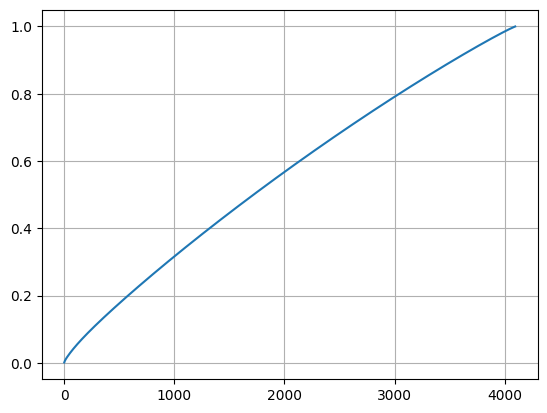

In [9]:
xsv = x.singular_values_
plt.plot(xsv.cumsum() / xsv.sum())
plt.grid()

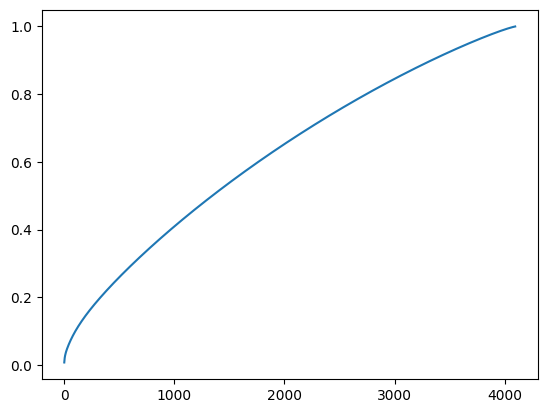

In [10]:
plt.plot(x.explained_variance_ratio_.cumsum())

In [11]:
import numpy as np

In [14]:
x.explained_variance_.shape

(4096,)

In [15]:
file_name = "data/llama-3-8B-embeddings-pca.npz"
np.savez(file_name, w=x.components_, v=x.singular_values_, explained_variance=x.explained_variance_, cov=x.get_covariance())